In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
adata =  sc.datasets.pbmc3k_processed()

In [3]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [4]:
import torch

In [5]:
import sys
sys.path.append("../src/")

In [7]:
%load_ext autoreload
%autoreload 2

import midaa

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import torch
torch.cuda.is_available()

True

In [12]:
input_matrix, norm_factor, distribution_type = midaa.get_input_params_adata(adata)

In [13]:
res = midaa.fit_MIDAA(
    [adata.X],
    [np.ones(adata.X.shape[0])],
    ["G"],
    hidden_dims_dec_common = [256,256],
    hidden_dims_dec_last = [512],
    hidden_dims_enc_ind = [512],
    hidden_dims_enc_common = [256,256],
    hidden_dims_enc_pre_Z = [128, 64],
    lr = 0.001,
    gamma_lr = 0.1,
    steps = 1000,
    narchetypes = 3,
    fix_Z = False)


ELBO: 29687876.00000  : 100%|██████████| 1000/1000 [00:27<00:00, 36.36it/s]
/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/pyro/primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(


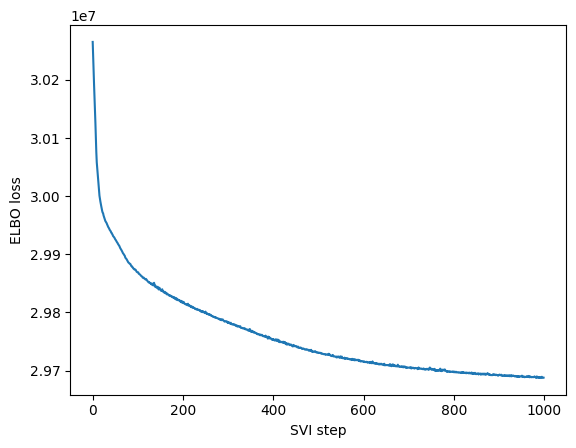

In [14]:
midaa.plot_ELBO(res)

(<Figure size 640x480 with 1 Axes>, <PolarAxes: >)

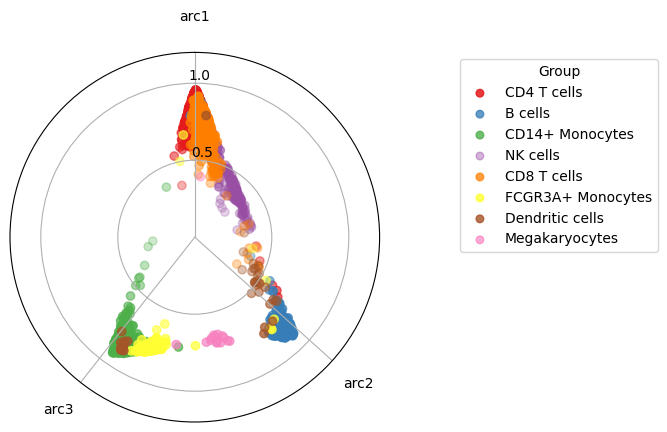

In [15]:
midaa.plot_archetypes_simplex(res, color_by = adata.obs["louvain"], cmap = "Set1")

In [16]:
col_names = [ "arc" + str(i+1) for i in range(res["inferred_quantities"]["A"].shape[1])]


Z_arc = pd.DataFrame(res["inferred_quantities"]["A"], columns= col_names, index = adata.obs_names )

In [17]:
adata =  sc.datasets.pbmc3k_processed()

In [18]:
adata.obs = pd.concat([adata.obs, Z_arc], axis=1)

/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


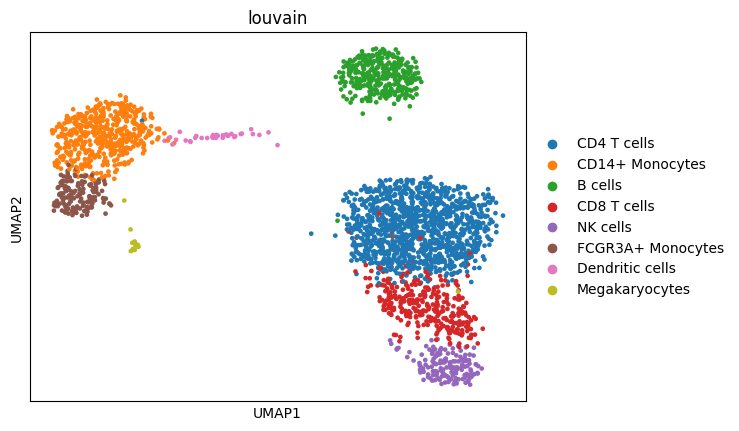

In [19]:
sc.pl.umap(adata, color="louvain")


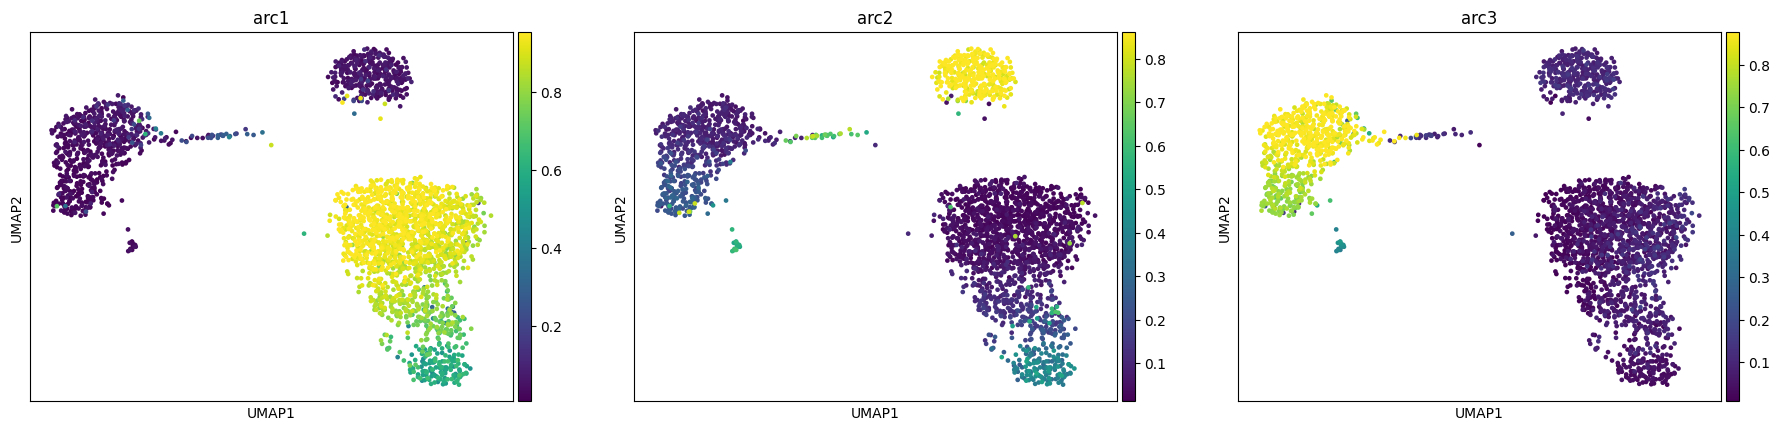

In [20]:
sc.pl.umap(adata, color=col_names, vmax="p95")


In [21]:
adata.obsm["X_aa"] = res["inferred_quantities"]["A"] @ res["inferred_quantities"]["archetypes_inferred"]

In [22]:
sc.pp.neighbors(adata, use_rep = "X_aa",n_neighbors=10)


<Axes: >

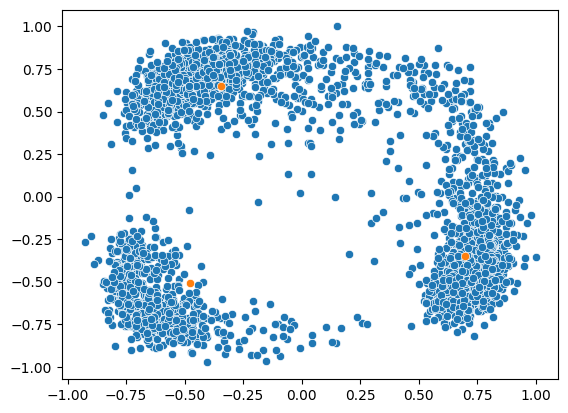

In [23]:
import seaborn as sns

sns.scatterplot(x = res["inferred_quantities"]["Z"][:,0], y = res["inferred_quantities"]["Z"][:,1])

sns.scatterplot(x = res["inferred_quantities"]["archetypes_inferred"][:,0], y = res["inferred_quantities"]["archetypes_inferred"][:,1])

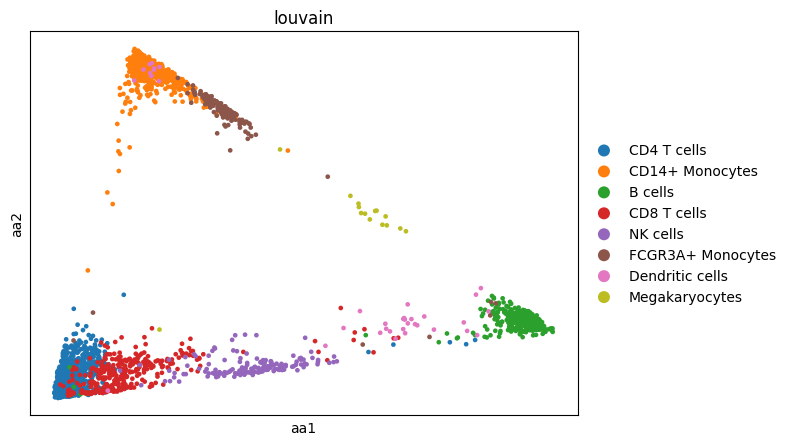

In [24]:
sc.pl.scatter(adata, basis= "aa", color="louvain")

In [ ]:
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata, color="louvain")


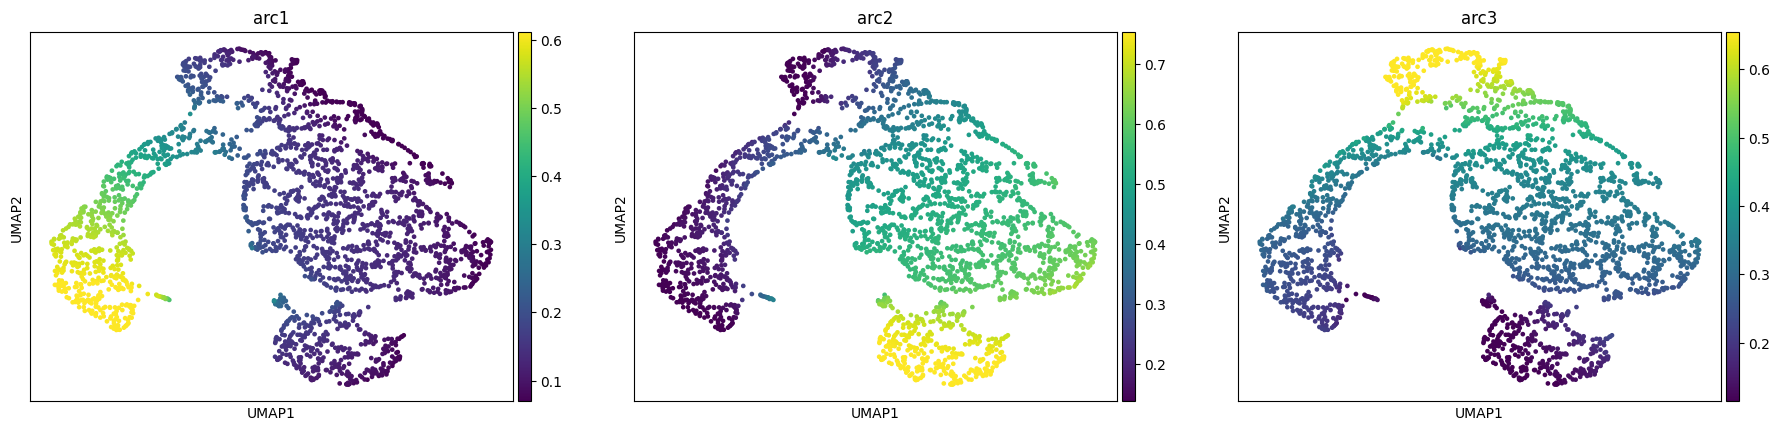

In [113]:
sc.pl.umap(adata, color=col_names, vmax='p95', vmin = "p05")

In [114]:
side_mat = pd.get_dummies(adata.obs["louvain"], prefix='louvain') 
side_mat = side_mat.to_numpy().astype(float)

In [115]:
side_mat

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [116]:
side_mat.sum(axis = 1)

array([1., 1., 1., ..., 1., 1., 1.])

In [117]:
res = scdeepaa.fit_deepAA(
    [adata.X],
    [np.ones(adata.X.shape[0])],
    ["G"],
    side_matrices = [side_mat], 
    input_types_side = ["C"],
    loss_weights_side = [1],
    loss_weights_reconstruction = [0],
    lr = 0.001,
    gamma_lr = 0.01,
    steps = 600,
    narchetypes = 8,
    fix_Z = False
    )

ELBO: 23404422.00000  :   1%|          | 4/600 [00:00<00:17, 34.15it/s]

Fitting full model!


ELBO: 23401354.00000  : 100%|██████████| 600/600 [00:15<00:00, 38.30it/s]
/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/pyro/primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

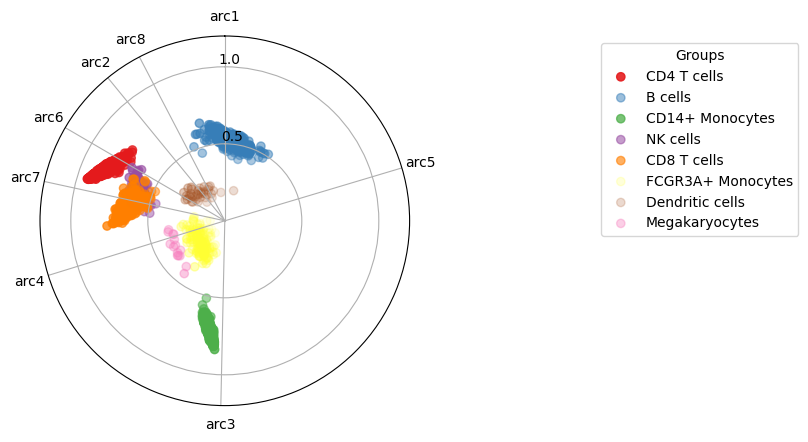

In [118]:
scdeepaa.plot_archetypes_simplex(res, color_by = adata.obs["louvain"], cmap = "Set1")

In [119]:
adata =  sc.datasets.pbmc3k_processed()

In [120]:
col_names = [ "arc" + str(i+1) for i in np.arange(res["hyperparametes"]["narchetypes"])]

In [121]:
Z_arc = pd.DataFrame(res["inferred_quantities"]["A"], columns= col_names, index = adata.obs_names )

In [122]:
adata.obs = pd.concat([adata.obs, Z_arc], axis=1)

/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1262: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


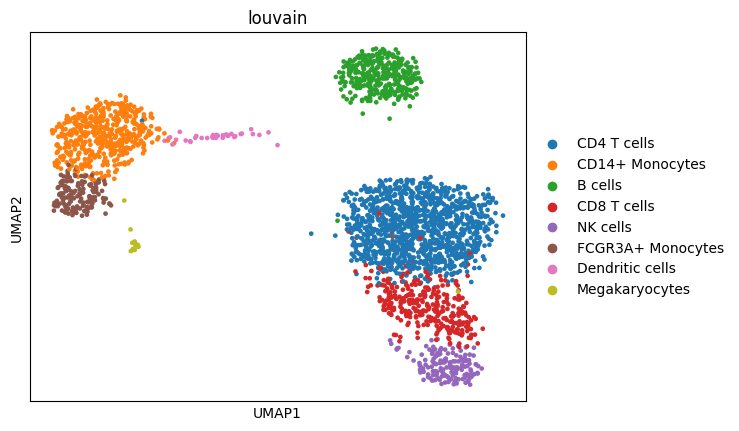

In [123]:
sc.pl.umap(adata, color="louvain")


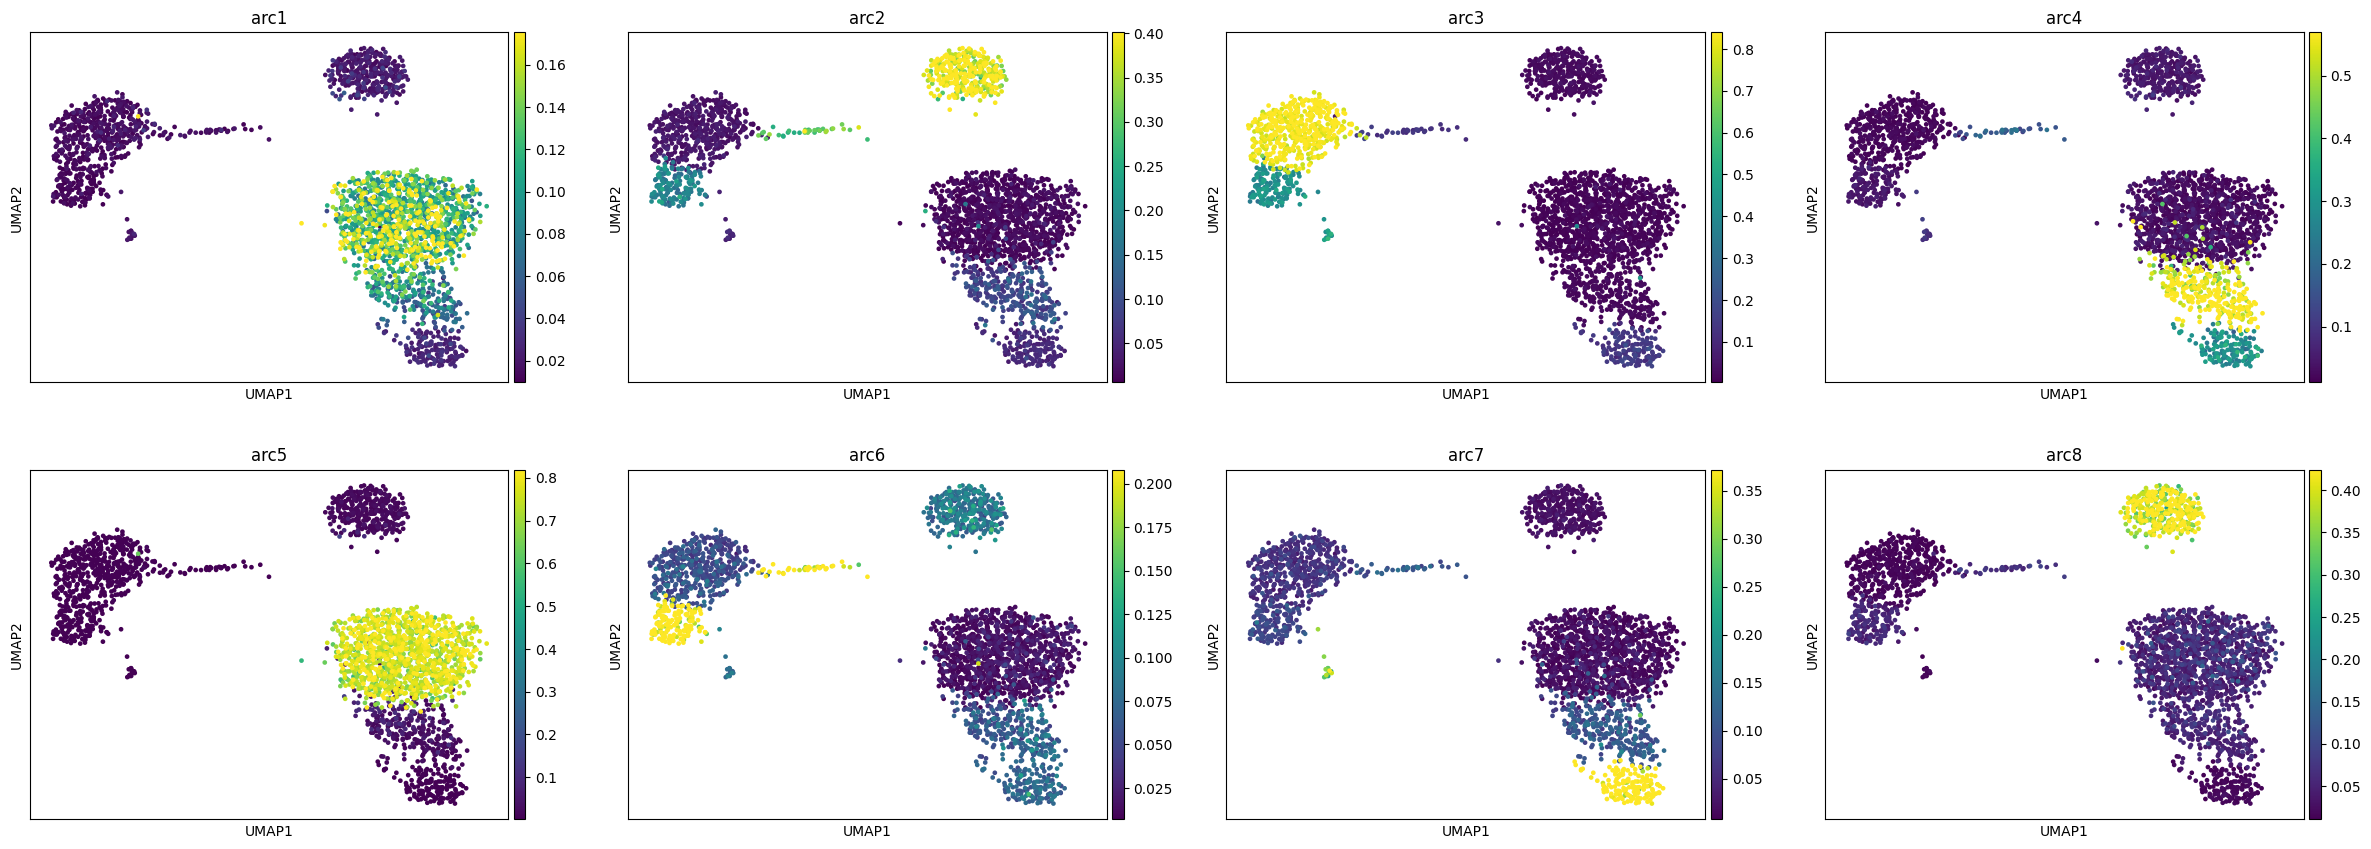

In [124]:
sc.pl.umap(adata, color=col_names, vmax='p95', vmin = "p05")

In [125]:
res["inferred_quantities"]["input_loss"]

array(-29471.264, dtype=float32)

In [126]:
res["inferred_quantities"]["side_loss"]

array(-29471.264, dtype=float32)

In [127]:
adata.obsm["X_aa"] = res["inferred_quantities"]["A"] @ res["inferred_quantities"]["archetypes_inferred"]

/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1262: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


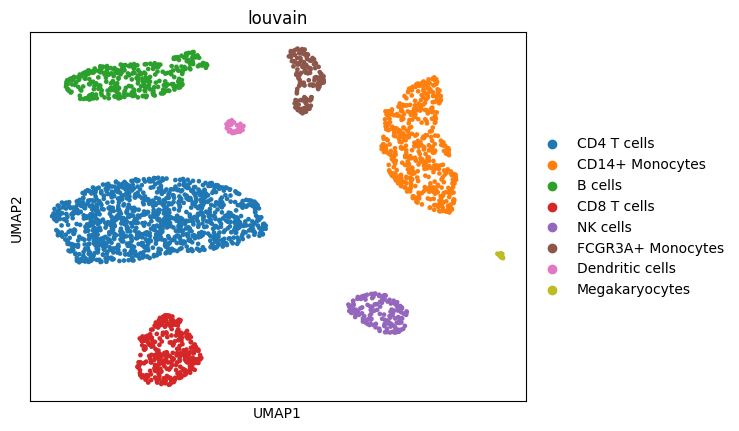

In [128]:
sc.pp.neighbors(adata, use_rep = "X_aa")
sc.tl.paga(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color="louvain")


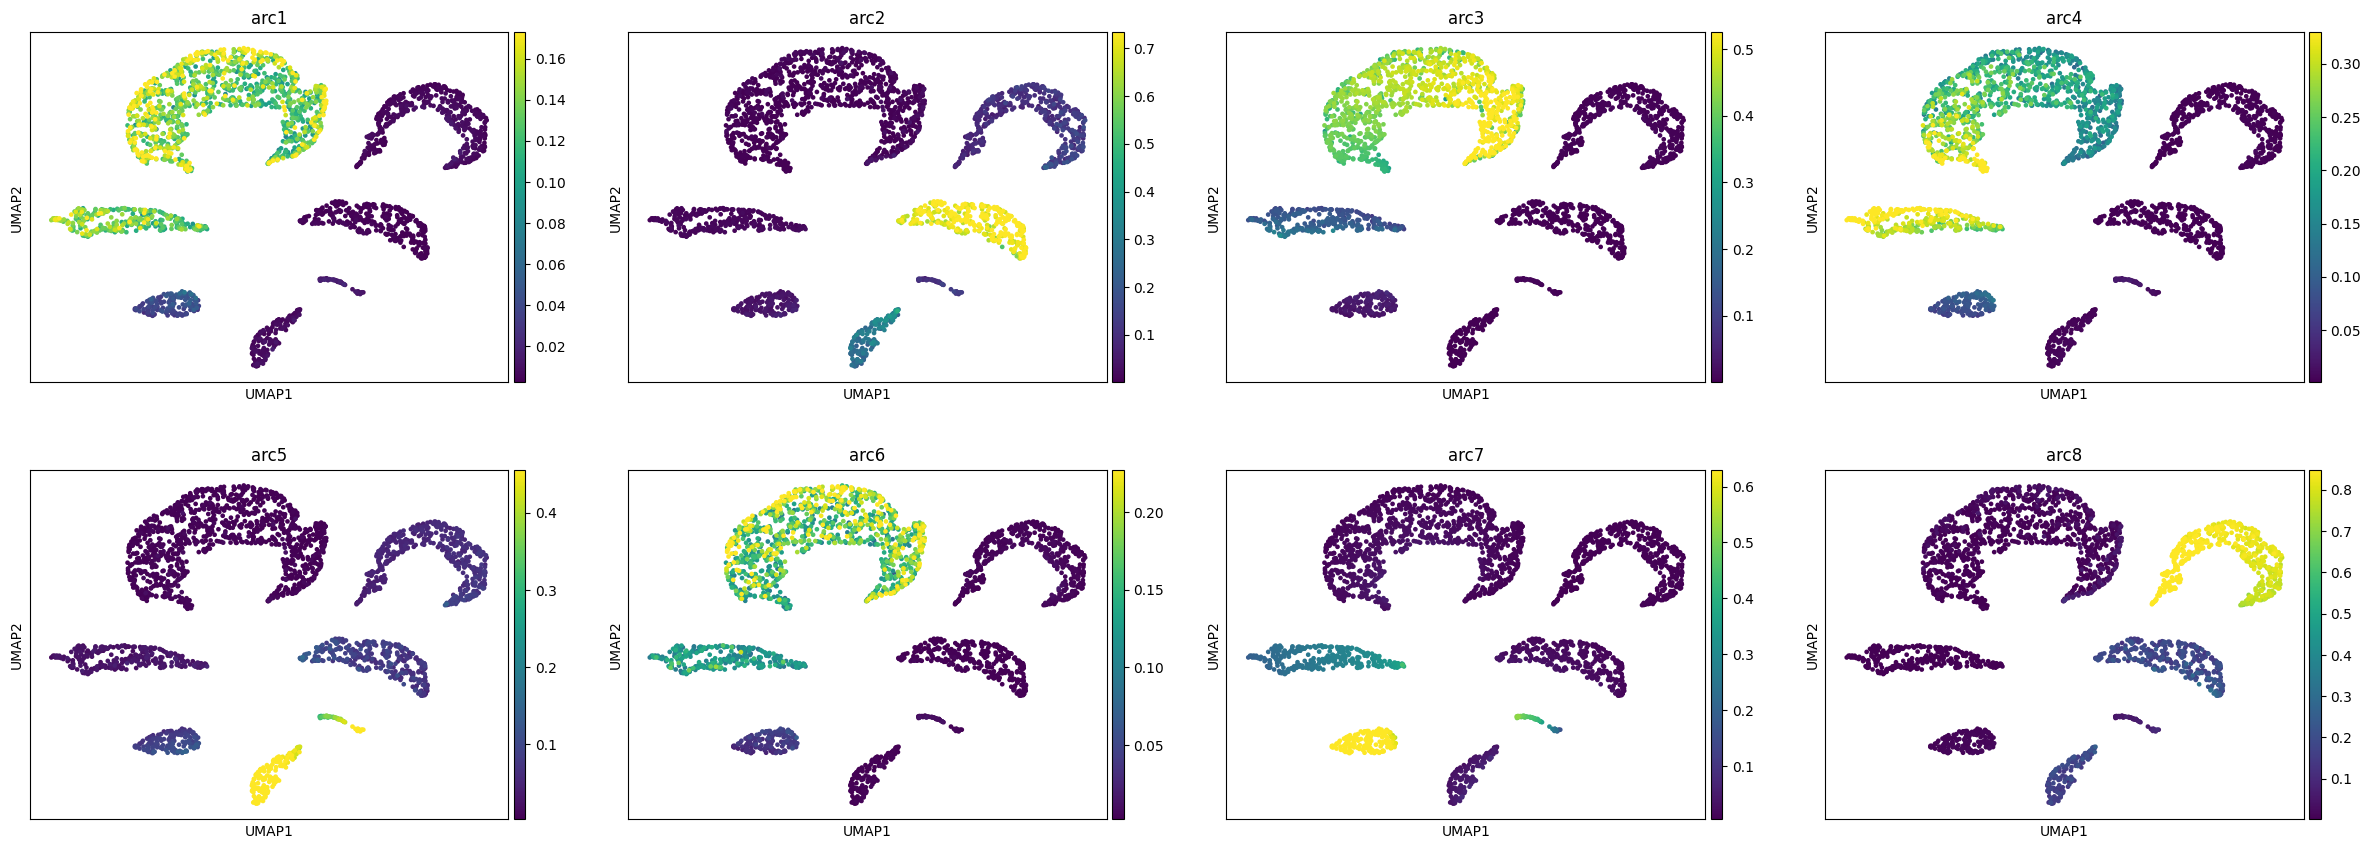

In [39]:
sc.pl.umap(adata, color=col_names, vmax='p95', vmin = "p05")

In [40]:
sc.tl.leiden(adata, resolution=0.05)


/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1262: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


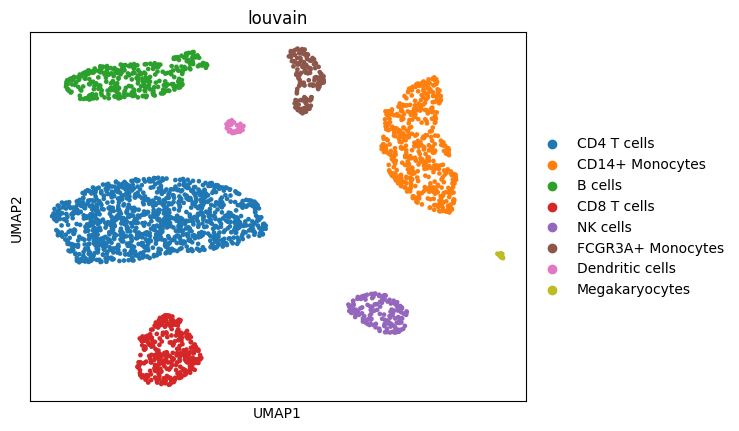

In [129]:
sc.pl.umap(adata, color="louvain")


In [130]:
res = scdeepaa.fit_deepAA(
    [adata.X],
    [np.ones(adata.X.shape[0])],
    ["G"],
    lr = 0.001,
    gamma_lr = 0.01,
    steps = 600,
    narchetypes = 8,
    fix_Z = False,
    just_VAE = True
    )

ELBO: 30019492.00000  :   1%|          | 5/600 [00:00<00:12, 47.33it/s]

Fitting full model!


ELBO: 29753088.00000  : 100%|██████████| 600/600 [00:11<00:00, 52.57it/s]
/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/pyro/primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(


In [131]:
adata =  sc.datasets.pbmc3k_processed()

In [132]:
adata.obsm["X_aa"] = res["inferred_quantities"]["Z"] 

/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1262: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


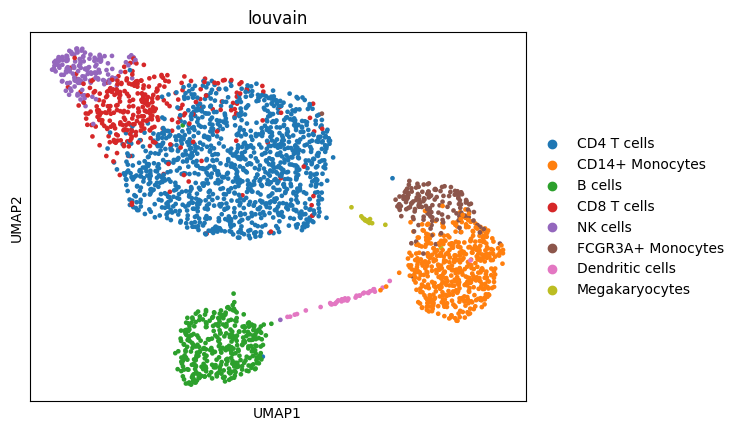

In [133]:
sc.pp.neighbors(adata, use_rep = "X_aa")
sc.tl.paga(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color="louvain")